## MLM initialized with ESM weights
### ESM embedding weights
First, we need to acquire our embedding weights from the ESM model. We are using the 320 dimension ESM model version.

In [1]:
import os
import torch
from transformers import AutoTokenizer, EsmModel 
from pnlp.embedding.tokenizer import token_to_index

def create_esm_embedding(embedding_dim:int, save_location:str) -> tuple:
    """
    Map our tokenizer tokens used for NLP embedding and BERT to
    Huggingface AutoTokenizer tokens and their corresponding embedding
    weights in the ESM model. Then create an embedding file (.pth) to 
    be utilized as pretrained embedding weights for loading into the BERT model.
    Returns name of the embedding file and the vocab size.

    Inputs:
    - embedding_dim: MUST be the same as embedding dimension to be used for the BERT model.
    - save_location: Location to save embedding file. 
    """
    embedding_file = os.path.join(save_location, f"esm_weights-embedding_dim{embedding_dim}.pth")

    # ESM input
    esm_version = "facebook/esm2_t6_8M_UR50D" 
    esm = EsmModel.from_pretrained(esm_version, cache_dir='../../../model_downloads')
    esm_embeddings = esm.embeddings.word_embeddings.weight
    tokenizer = AutoTokenizer.from_pretrained(esm_version, cache_dir='../../../model_downloads')

    # Identifying tokens that exist in both datasets
    esm_tokens = tokenizer.get_vocab()
    main_tokens = token_to_index

    # Manual mapping for special tokens that exist in both sets, main tokens as keys
    # '<TRUNCATED>' alternate does not exist in ESM, will just make sure we do not truncate
    special_token_mapping = {'<START>':'<cls>', 
                             '<PAD>':'<pad>', 
                             '<END>':'<eos>', 
                             '<OTHER>':'<unk>',
                             '<MASK>':'<mask>'}

    # Create the dictionary to map ESM embeddings to our tokens
    esm_embedding_map = {}
    for token in main_tokens:
        if token in esm_tokens:
            esm_embedding_map[main_tokens[token]] = esm_embeddings[esm_tokens[token]]
        elif token in special_token_mapping and special_token_mapping[token] in esm_tokens:
            esm_embedding_map[main_tokens[token]] = esm_embeddings[esm_tokens[special_token_mapping[token]]]

    # Create a ESM embedding tensor that can be loaded into BERT 
    vocab_size = len(esm_embedding_map.keys())
    esm_embeddings = torch.zeros(vocab_size, embedding_dim)  # Initialize a tensor of zeros
    for token, embedding in esm_embedding_map.items():
        esm_embeddings[token] = embedding
    torch.save(esm_embeddings, embedding_file)

    return embedding_file, vocab_size

data_dir = "."
create_esm_embedding(embedding_dim=320, save_location=data_dir)

/data/miniconda3/envs/spike_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.weight', 'esm.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


('./esm_weights-embedding_dim320.pth', 27)

Now we can load from the path `./esm_weights-embedding_dim320.pth` for our embedding weights, and know that 27 is our `vocab_size` since we are missing the truncating token. Since we created this here, we won't need to put this in the model runner file.

---

### Testing the new embedding weights
We'll import the model from `pnlp` module. Let's check to make sure that we are properly initializing the weights.

In [2]:
from pnlp.model.language import BERT, ProteinLM
from pnlp.embedding.tokenizer import ProteinTokenizer

data_dir = "."

# BERT input
max_len = 280
mask_prob = 0.15
embedding_dim = 320 
dropout = 0.1
n_transformer_layers = 12
n_attn_heads = 10

bert = BERT(embedding_dim, dropout, max_len, mask_prob, n_transformer_layers, n_attn_heads)
print(bert.embedding.token_embedding.weight)
print(bert.embedding.token_embedding.weight.shape)

bert.embedding.load_pretrained_embeddings(os.path.join(data_dir, 'esm_weights-embedding_dim320.pth'), no_grad=False)
print(bert.embedding.token_embedding.weight)
print(bert.embedding.token_embedding.weight.shape)

Parameter containing:
tensor([[-0.1799, -0.0155, -1.0300,  ...,  0.2880,  0.1683,  0.5769],
        [ 0.2410,  0.5072,  0.9027,  ..., -0.0086, -0.7667,  0.0059],
        [ 0.1819, -0.3939, -0.2074,  ..., -1.5204,  1.2693,  0.8639],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 1.2790,  1.0738, -0.1186,  ...,  1.1395,  0.8604,  0.4994],
        [ 0.7901,  0.2815, -0.2609,  ...,  0.1385,  0.1496,  1.6533]],
       requires_grad=True)
torch.Size([28, 320])
Parameter containing:
tensor([[-0.0667, -0.0119,  0.0086,  ...,  0.0146, -0.0439, -0.1935],
        [ 0.3459, -0.0628, -0.0804,  ..., -0.0846, -0.0104,  0.2617],
        [-0.0905, -0.0210,  0.0079,  ...,  0.0646,  0.2185, -0.0343],
        ...,
        [ 0.0731, -0.3081, -0.1170,  ..., -0.2206, -0.3433, -0.0015],
        [-0.2225, -0.9604, -0.0598,  ..., -0.2300, -0.0948,  0.3914],
        [-0.2281, -0.9619, -0.0608,  ..., -0.2356, -0.0932,  0.3992]],
       requires_grad=True)
torch.Size([

Okay, the weights definitely look different after loading in the pretrained embedding weights from the ESM2 model.

---

### Defining the dataset
We tested this in `RBD_processing.ipynb`.

In [3]:
import os
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader

# DATASET    
class RBDDataset(Dataset):
    def __init__(self, csv_file:str):

        try:
            self.full_df = pd.read_csv(csv_file, sep=',', header=0)
        except (FileNotFoundError, pd.errors.ParserError, Exception) as e:
            print(f"Error reading in .csv file: {csv_file}\n{e}", file=sys.stderr)
            sys.exit(1)

    def __len__(self) -> int:
        return len(self.full_df)

    def __getitem__(self, idx):
        # label, seq, target
        return self.full_df['seq_id'][idx], self.full_df['sequence'][idx]

### Defining the scheduler for optimizer

In [4]:
class ScheduledOptim():
    """A simple wrapper class for learning rate scheduling from BERT-pytorch.

    Author: codertimo
    https://github.com/codertimo/BERT-pytorch/blob/master/bert_pytorch/trainer/optim_schedule.py
    """

    def __init__(self, optimizer, d_model: int, n_warmup_steps):
        self._optimizer=optimizer
        self.n_warmup_steps = n_warmup_steps
        self.n_current_steps = 0
        self.init_lr = np.power(d_model, -0.5)

    def step_and_update_lr(self):
        "Step with the inner optimizer"
        self._update_learning_rate()
        self._optimizer.step()

    def zero_grad(self):
        "Zero out the gradients by the inner optimizer"
        self._optimizer.zero_grad()

    def _get_lr_scale(self):
        return np.min([
            np.power(self.n_current_steps, -0.5),
            np.power(self.n_warmup_steps, -1.5) * self.n_current_steps])

    def _update_learning_rate(self):
        """Learning rate scheduling per step"""
        self.n_current_steps += 1
        lr = self.init_lr * self._get_lr_scale()

        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr

### Defining some helper functions

In [5]:
import re
import sys
import math
import tqdm
import time
import datetime
from typing import Union
from torch import nn
import seaborn as sns
import matplotlib.pyplot as plt
from prettytable import PrettyTable

# HELPER FUNCTIONS
def count_parameters(model):
    """
    Count model parameters and print a summary

    A nice hack from:
    https://stackoverflow.com/a/62508086/1992369
    """
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}\n")
    return total_params

def save_model(model, optimizer, path_to_pth, epoch, accuracy, loss):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'accuracy': accuracy,
        'loss': loss}, path_to_pth
    )
    print(f"Model and optimizer state saved to {path_to_pth}")

def load_model(model, optimizer, saved_model_pth, device):
    saved_state = torch.load(saved_model_pth, map_location=device)
    model.load_state_dict(saved_state['model_state_dict'])
    optimizer.load_state_dict(saved_state['optimizer_state_dict'])
    epoch = saved_state['epoch']
    accuracy = saved_state['accuracy']
    loss = saved_state['loss']
    print(f"Loaded model from {saved_model_pth} at epoch {epoch}, accuracy {accuracy}, loss {loss}")
    return model.to(device), optimizer, epoch, accuracy, loss

def load_model_checkpoint(path_to_pth, metrics_csv, starting_epoch):
    """ Load model data csv, and model pth. """
    folder_path = os.path.dirname(path_to_pth)
    files_in_folder = os.listdir(folder_path)
    metrics_file_name = [file for file in files_in_folder if file.endswith("_metrics.csv")][0]
    saved_metrics_file = os.path.join(folder_path, metrics_file_name)

    with open(saved_metrics_file, "r") as fa, open(metrics_csv, "w") as fb:
        header = fa.readline()
        fb.write(header)

        for line in fa:
            epoch = int(line.split(',')[0])
            if epoch == starting_epoch:
                break
            fb.write(line)

def plot_log_file(metrics_csv, metrics_img):
    df = pd.read_csv(metrics_csv)

    sns.set_theme(style="darkgrid")
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 18))  # 2 rows, 1 column
    fontsize = 28

    # Plot Loss
    ax1.plot(df['Epoch'], df['Train Loss'], label='Train Loss', color='tab:red', linewidth=3)
    ax1.plot(df['Epoch'], df['Test Loss'], label='Test Loss', color='tab:orange', linewidth=3)
    ax1.tick_params(axis='x', labelsize=fontsize)
    ax1.set_ylim(-0.5e6, 14e6) 
    ax1.set_ylabel('Loss', fontsize=fontsize)
    ax1.tick_params(axis='y', labelsize=fontsize)
    ax1.legend(loc='upper right', fontsize=fontsize)

    # Plot Accuracy
    ax2.plot(df['Epoch'], df['Train Accuracy'], label='Train Accuracy', color='tab:blue', linewidth=3)
    ax2.plot(df['Epoch'], df['Test Accuracy'], label='Test Accuracy', color='tab:green', linewidth=3)
    ax2.set_xlabel('Epochs', fontsize=fontsize)
    ax2.tick_params(axis='x', labelsize=fontsize)
    ax2.set_ylim(0, 100) 
    ax2.set_ylabel('Accuracy', fontsize=fontsize)
    ax2.tick_params(axis='y', labelsize=fontsize)
    ax2.legend(loc='lower right', fontsize=fontsize)

    plt.tight_layout()
    plt.savefig(metrics_img, format='pdf')
    plt.savefig(metrics_img.replace('.pdf', '.png'), format='png')

def plot_aa_preds_heatmap(preds_csv, preds_img):
    """ Plots heatmap of expected vs predicted amino acid incorrect prediction counts. Expected on x axis. """
    df = pd.read_csv(preds_csv)

    # Create a DataFrame with all possible amino acid combinations
    ALL_AAS = 'ACDEFGHIKLMNPQRSTVWY'
    all_combinations = [(e_aa, p_aa) for e_aa in ALL_AAS for p_aa in ALL_AAS]
    all_df = pd.DataFrame(all_combinations, columns=["Expected", "Predicted"])

    # Split 'expected_aa->predicted_aa' into separate columns
    df[['Expected', 'Predicted']] = df['expected_aa->predicted_aa'].str.split('->', expand=True)

    # Ensure that the epoch columns are numeric and fill any NaNs with 0
    epoch_columns = df.columns[1:-2]  # Assuming epoch columns start at index 1 and go up to the second last column
    df[epoch_columns] = df[epoch_columns].apply(pd.to_numeric, errors='coerce').fillna(0)

    # Sum the counts across all epochs to get the total error count for each expected->predicted pair
    df['Total Count'] = df[epoch_columns].sum(axis=1)

    # Merge with all possible amino acid combinations so missing pairs get a count of 0
    df = pd.merge(all_df, df[['Expected', 'Predicted', 'Total Count']], how="left", on=["Expected", "Predicted"])
    df["Total Count"].fillna(0, inplace=True)

    # Calculate the total counts for each expected amino acid
    total_counts = df.groupby("Expected")["Total Count"].sum()
    df["Expected Total"] = df["Expected"].map(total_counts)

    # Calculate error percentage
    df["Error Percentage"] = (df["Total Count"] / df["Expected Total"]) * 100
    df["Error Percentage"].fillna(0, inplace=True)

    # Pivot the DataFrame to create a heatmap data structure
    heatmap_data = df.pivot_table(index="Predicted", columns="Expected", values="Error Percentage")

    # Set figure size
    plt.figure(figsize=(16, 9))
    fontsize=16

    # Plot
    cmap = sns.color_palette("rocket_r", as_cmap=True)
    heatmap = sns.heatmap(
        heatmap_data,
        annot=True, fmt=".2f",
        linewidth=.5,
        cmap=cmap, vmin=0, vmax=100,
        annot_kws={"size": 13},
        cbar_kws={'drawedges': False, 'label': 'Prediction Rate (%)'}
    )

    colorbar = heatmap.collections[0].colorbar
    colorbar.ax.tick_params(labelsize=fontsize)  # Set colorbar tick label size
    colorbar.set_label('Prediction Rate (%)', size=fontsize)  # Set colorbar label size

    plt.ylabel('Predicted Amino Acid', fontsize=fontsize)
    plt.xlabel('Expected Amino Acid', fontsize=fontsize)
    plt.xticks(rotation=0, fontsize=fontsize-2)
    plt.yticks(fontsize=fontsize-2)

    plt.tight_layout()
    plt.savefig(preds_img, format='pdf')
    plt.savefig(preds_img.replace('.pdf', '.png'), format='png')

In [9]:
from collections import defaultdict

# MODEL RUNNING
def run_model(model, tokenizer, train_data_loader, test_data_loader, n_epochs: int, lr:float, max_batch: Union[int, None], device: str, run_dir: str, save_as: str, saved_model_pth:str=None, from_checkpoint:bool=False):
    """ Run a model through train and test epochs. """

    model = model.to(device)
    loss_fn = nn.CrossEntropyLoss(reduction='sum').to(device)  # sum of CEL at batch level.
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=0.01)
    optimizer_scheduler = ScheduledOptim(
        optimizer, 
        d_model=model.bert.embedding_dim, 
        n_warmup_steps=(len(train_data_loader.dataset) / train_data_loader.batch_size) * 0.1
    ) 

    starting_epoch = 1
    best_accuracy = 0
    best_loss = float('inf')

    # Load saved model if provided
    if saved_model_pth is not None:
        model, optimizer, starting_epoch, best_accuracy, best_loss = load_model(model, optimizer, saved_model_pth, device)
        starting_epoch += 1

    start_time = time.time()
    
    metrics_csv = os.path.join(run_dir, f"{save_as}_metrics.csv")
    metrics_img = os.path.join(run_dir, f"{save_as}_metrics.pdf")
    preds_csv = os.path.join(run_dir, f"{save_as}_predictions.csv")
    preds_img = os.path.join(run_dir, f"{save_as}_predictions.pdf")
    aa_preds_tracker = {}
    
    # If saved model, skip to predictions 
    # Except when from checkpoint (still need saved model)
    if saved_model_pth is None or (from_checkpoint and saved_model_pth is not None):

        if starting_epoch > n_epochs:
            raise ValueError(f"Starting epoch ({starting_epoch}) is greater than the total number of epochs to run ({n_epochs}). Adjust the number of epochs, 'n_epochs'.")
        
        # Write metrics
        with open(metrics_csv, "a") as fa:
            if from_checkpoint: load_model_checkpoint(saved_model_pth, metrics_csv, starting_epoch)
            else: fa.write(f"Epoch,Train Accuracy,Train Loss,Test Accuracy,Test Loss\n")

            for epoch in range(starting_epoch, n_epochs + 1):
                if not max_batch:
                    max_batch = len(train_data_loader)

                train_accuracy, train_loss = epoch_iteration(model, tokenizer, loss_fn, optimizer_scheduler, train_data_loader, epoch, max_batch, device, mode='train')
                test_accuracy, test_loss, aa_pred_counter = epoch_iteration(model, tokenizer, loss_fn, optimizer_scheduler, test_data_loader, epoch, max_batch, device, mode='test')

                print(f'Epoch {epoch} | Train Accuracy: {train_accuracy:.4f}, Train Loss: {train_loss:.4f}')
                print(f'{" "*(7+len(str(epoch)))}| Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}\n')          
                fa.write(f"{epoch},{train_accuracy},{train_loss},{test_accuracy},{test_loss}\n")
                fa.flush()

                for key in aa_pred_counter:
                    if key not in aa_preds_tracker :
                        aa_preds_tracker[key] = {}
                    aa_preds_tracker[key][epoch] = aa_pred_counter.get(key)

                # Save best
                if test_accuracy > best_accuracy or (test_accuracy == best_accuracy and test_loss < best_loss):
                    best_accuracy = test_accuracy
                    best_loss = test_loss
                    model_path = os.path.join(run_dir, f'best_saved_model.pth')
                    print(f"NEW BEST model: accuracy {best_accuracy:.4f} and loss {best_loss:.4f}")
                    save_model(model, optimizer, model_path, epoch, best_accuracy, best_loss)
                
                # Save every 10 epochs
                if epoch > 0 and epoch % 10 == 0:
                    model_path = os.path.join(run_dir, f'saved_model-epoch_{epoch}.pth')
                    save_model(model, optimizer, model_path, epoch, test_accuracy, test_loss)

                # Save checkpoint 
                model_path = os.path.join(run_dir, f'checkpoint_saved_model.pth')
                save_model(model, optimizer, model_path, epoch, test_accuracy, test_loss)
                    
                print("")
        
        plot_log_file(metrics_csv, metrics_img)

        # Write Predictions
        with open(preds_csv, 'w') as fb:
            header = ", ".join(f"epoch {epoch}" for epoch in range(1, n_epochs + 1))
            header = f"expected_aa->predicted_aa, {header}\n"
            fb.write(header)

            for key in aa_preds_tracker:
                aa_preds_tracker[key] = [aa_preds_tracker[key].get(epoch, 0) for epoch in range(1, n_epochs + 1)]
                data_row = ", ".join(str(val) for val in aa_preds_tracker[key])
                fb.write(f"{key}, {data_row}\n")

        plot_aa_preds_heatmap(preds_csv, preds_img)

    # End timer and print duration
    end_time = time.time()
    duration = end_time - start_time
    formatted_duration = str(datetime.timedelta(seconds=duration))
    days, hrs, minutes = formatted_duration.split(":")
    print(f'Training and testing complete in: {days} days, {hrs} hours, {minutes} minutes.')

def epoch_iteration(model, tokenizer, loss_fn, optimizer_scheduler, data_loader, epoch, max_batch, device, mode):
    """ Used in run_model. """
    
    model.train() if mode=='train' else model.eval()

    data_iter = tqdm.tqdm(enumerate(data_loader),
                          desc=f'Epoch_{mode}: {epoch}',
                          total=len(data_loader),
                          bar_format='{l_bar}{r_bar}')

    total_loss = 0
    total_items = 0
    total_masked = 0
    correct_predictions = 0
    aa_pred_counter = defaultdict(int)

    for batch, batch_data in data_iter:
        if max_batch > 0 and batch >= max_batch:
            break

        seq_ids, seqs = batch_data
        masked_tokenized_seqs = tokenizer(seqs).to(device) 
        unmasked_tokenized_seqs = tokenizer._batch_pad(seqs).to(device)
   
        if mode == 'train':
            optimizer_scheduler.zero_grad()
            preds = model(masked_tokenized_seqs)
            batch_loss = loss_fn(preds.transpose(1, 2), unmasked_tokenized_seqs)
            batch_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer_scheduler.step_and_update_lr()

        else:
            with torch.no_grad():
                preds = model(masked_tokenized_seqs)
                batch_loss = loss_fn(preds.transpose(1, 2), unmasked_tokenized_seqs)

        # Loss
        total_loss += batch_loss.item()

        # Accuracy
        predicted_tokens = torch.max(preds, dim=-1)[1]
        masked_locations = torch.nonzero(torch.eq(masked_tokenized_seqs, token_to_index['<MASK>']), as_tuple=True)
        correct_predictions += torch.eq(predicted_tokens[masked_locations], unmasked_tokenized_seqs[masked_locations]).sum().item()
        total_masked += masked_locations[0].numel()     

        # STATS
        if mode == "test":
            token_to_aa = {i:aa for i, aa in enumerate('ACDEFGHIKLMNPQRSTUVWXY')}                
            # Create a list of keys from masked_loactions in format "expected_aa -> predicted_aa" where expected_aa != predicted_aa
            aa_keys = [f"{token_to_aa.get(token.item())}->{token_to_aa.get(pred_token.item())}" for token, pred_token in zip(unmasked_tokenized_seqs[masked_locations], predicted_tokens[masked_locations])]
            # Update the tracker as going through keys (counting occurences)
            aa_pred_counter.update((aa_key, aa_pred_counter[aa_key] + 1) for aa_key in aa_keys)  

    accuracy = (correct_predictions / total_masked) * 100
    if mode == "train": return accuracy, total_loss
    else: return accuracy, total_loss, aa_pred_counter

+-----------------------------------------------------------+------------+
|                          Modules                          | Parameters |
+-----------------------------------------------------------+------------+
|           bert.embedding.token_embedding.weight           |    8640    |
|    bert.transformer_blocks.0.attention.linears.0.weight   |   102400   |
|     bert.transformer_blocks.0.attention.linears.0.bias    |    320     |
|    bert.transformer_blocks.0.attention.linears.1.weight   |   102400   |
|     bert.transformer_blocks.0.attention.linears.1.bias    |    320     |
|    bert.transformer_blocks.0.attention.linears.2.weight   |   102400   |
|     bert.transformer_blocks.0.attention.linears.2.bias    |    320     |
|    bert.transformer_blocks.0.attention.linears.3.weight   |   102400   |
|     bert.transformer_blocks.0.attention.linears.3.bias    |    320     |
|  bert.transformer_blocks.0.attention.output_linear.weight |   102400   |
|   bert.transformer_bloc

Epoch_test: 1: 100%|| 1086/1086 [01:59<00:00,  9.06it/s]


Epoch 1 | Train Accuracy: 63.9332, Train Loss: 12461225.7988
        | Test Accuracy: 93.9936, Test Loss: 825314.6203

NEW BEST model: accuracy 93.9936 and loss 825314.6203
Model and optimizer state saved to ./run_results/mlm-esm_init/mlm-esm_init-rbd-2024-09-24_18-26/best_saved_model.pth
Model and optimizer state saved to ./run_results/mlm-esm_init/mlm-esm_init-rbd-2024-09-24_18-26/checkpoint_saved_model.pth



Epoch_test: 2: 100%|| 1086/1086 [02:00<00:00,  9.00it/s]


Epoch 2 | Train Accuracy: 77.9550, Train Loss: 7164941.4825
        | Test Accuracy: 95.8028, Test Loss: 603209.3067

NEW BEST model: accuracy 95.8028 and loss 603209.3067
Model and optimizer state saved to ./run_results/mlm-esm_init/mlm-esm_init-rbd-2024-09-24_18-26/best_saved_model.pth
Model and optimizer state saved to ./run_results/mlm-esm_init/mlm-esm_init-rbd-2024-09-24_18-26/checkpoint_saved_model.pth



Epoch_test: 3: 100%|| 1086/1086 [02:00<00:00,  9.03it/s]

Epoch 3 | Train Accuracy: 81.5542, Train Loss: 6298025.0753
        | Test Accuracy: 95.4360, Test Loss: 521963.8731

Model and optimizer state saved to ./run_results/mlm-esm_init/mlm-esm_init-rbd-2024-09-24_18-26/checkpoint_saved_model.pth




Epoch_test: 4: 100%|| 1086/1086 [01:58<00:00,  9.15it/s]


Epoch 4 | Train Accuracy: 83.3168, Train Loss: 5861658.0524
        | Test Accuracy: 96.1096, Test Loss: 470603.1898

NEW BEST model: accuracy 96.1096 and loss 470603.1898
Model and optimizer state saved to ./run_results/mlm-esm_init/mlm-esm_init-rbd-2024-09-24_18-26/best_saved_model.pth
Model and optimizer state saved to ./run_results/mlm-esm_init/mlm-esm_init-rbd-2024-09-24_18-26/checkpoint_saved_model.pth



Epoch_test: 5: 100%|| 1086/1086 [02:01<00:00,  8.94it/s]

Epoch 5 | Train Accuracy: 84.3911, Train Loss: 5557881.2520
        | Test Accuracy: 95.9354, Test Loss: 460822.4367

Model and optimizer state saved to ./run_results/mlm-esm_init/mlm-esm_init-rbd-2024-09-24_18-26/checkpoint_saved_model.pth




Epoch_test: 6: 100%|| 1086/1086 [02:00<00:00,  9.00it/s]


Epoch 6 | Train Accuracy: 85.0385, Train Loss: 5398881.2309
        | Test Accuracy: 96.1190, Test Loss: 448917.2685

NEW BEST model: accuracy 96.1190 and loss 448917.2685
Model and optimizer state saved to ./run_results/mlm-esm_init/mlm-esm_init-rbd-2024-09-24_18-26/best_saved_model.pth
Model and optimizer state saved to ./run_results/mlm-esm_init/mlm-esm_init-rbd-2024-09-24_18-26/checkpoint_saved_model.pth



Epoch_test: 7: 100%|| 1086/1086 [02:01<00:00,  8.94it/s]

Epoch 7 | Train Accuracy: 85.2821, Train Loss: 5328145.5082
        | Test Accuracy: 96.0302, Test Loss: 438441.0281

Model and optimizer state saved to ./run_results/mlm-esm_init/mlm-esm_init-rbd-2024-09-24_18-26/checkpoint_saved_model.pth




Epoch_test: 8: 100%|| 1086/1086 [01:59<00:00,  9.06it/s]

Epoch 8 | Train Accuracy: 85.6673, Train Loss: 5230681.9825
        | Test Accuracy: 95.4805, Test Loss: 437121.6696

Model and optimizer state saved to ./run_results/mlm-esm_init/mlm-esm_init-rbd-2024-09-24_18-26/checkpoint_saved_model.pth




Epoch_test: 9: 100%|| 1086/1086 [01:59<00:00,  9.10it/s]

Epoch 9 | Train Accuracy: 85.9127, Train Loss: 5162699.7662
        | Test Accuracy: 96.0651, Test Loss: 420148.5642

Model and optimizer state saved to ./run_results/mlm-esm_init/mlm-esm_init-rbd-2024-09-24_18-26/checkpoint_saved_model.pth




Epoch_test: 10: 100%|| 1086/1086 [02:00<00:00,  9.02it/s]


Epoch 10 | Train Accuracy: 86.1420, Train Loss: 5086756.9480
         | Test Accuracy: 96.0747, Test Loss: 414507.9592

Model and optimizer state saved to ./run_results/mlm-esm_init/mlm-esm_init-rbd-2024-09-24_18-26/saved_model-epoch_10.pth
Model and optimizer state saved to ./run_results/mlm-esm_init/mlm-esm_init-rbd-2024-09-24_18-26/checkpoint_saved_model.pth

Training and testing complete in: 1 days, 19 hours, 23.502920 minutes.


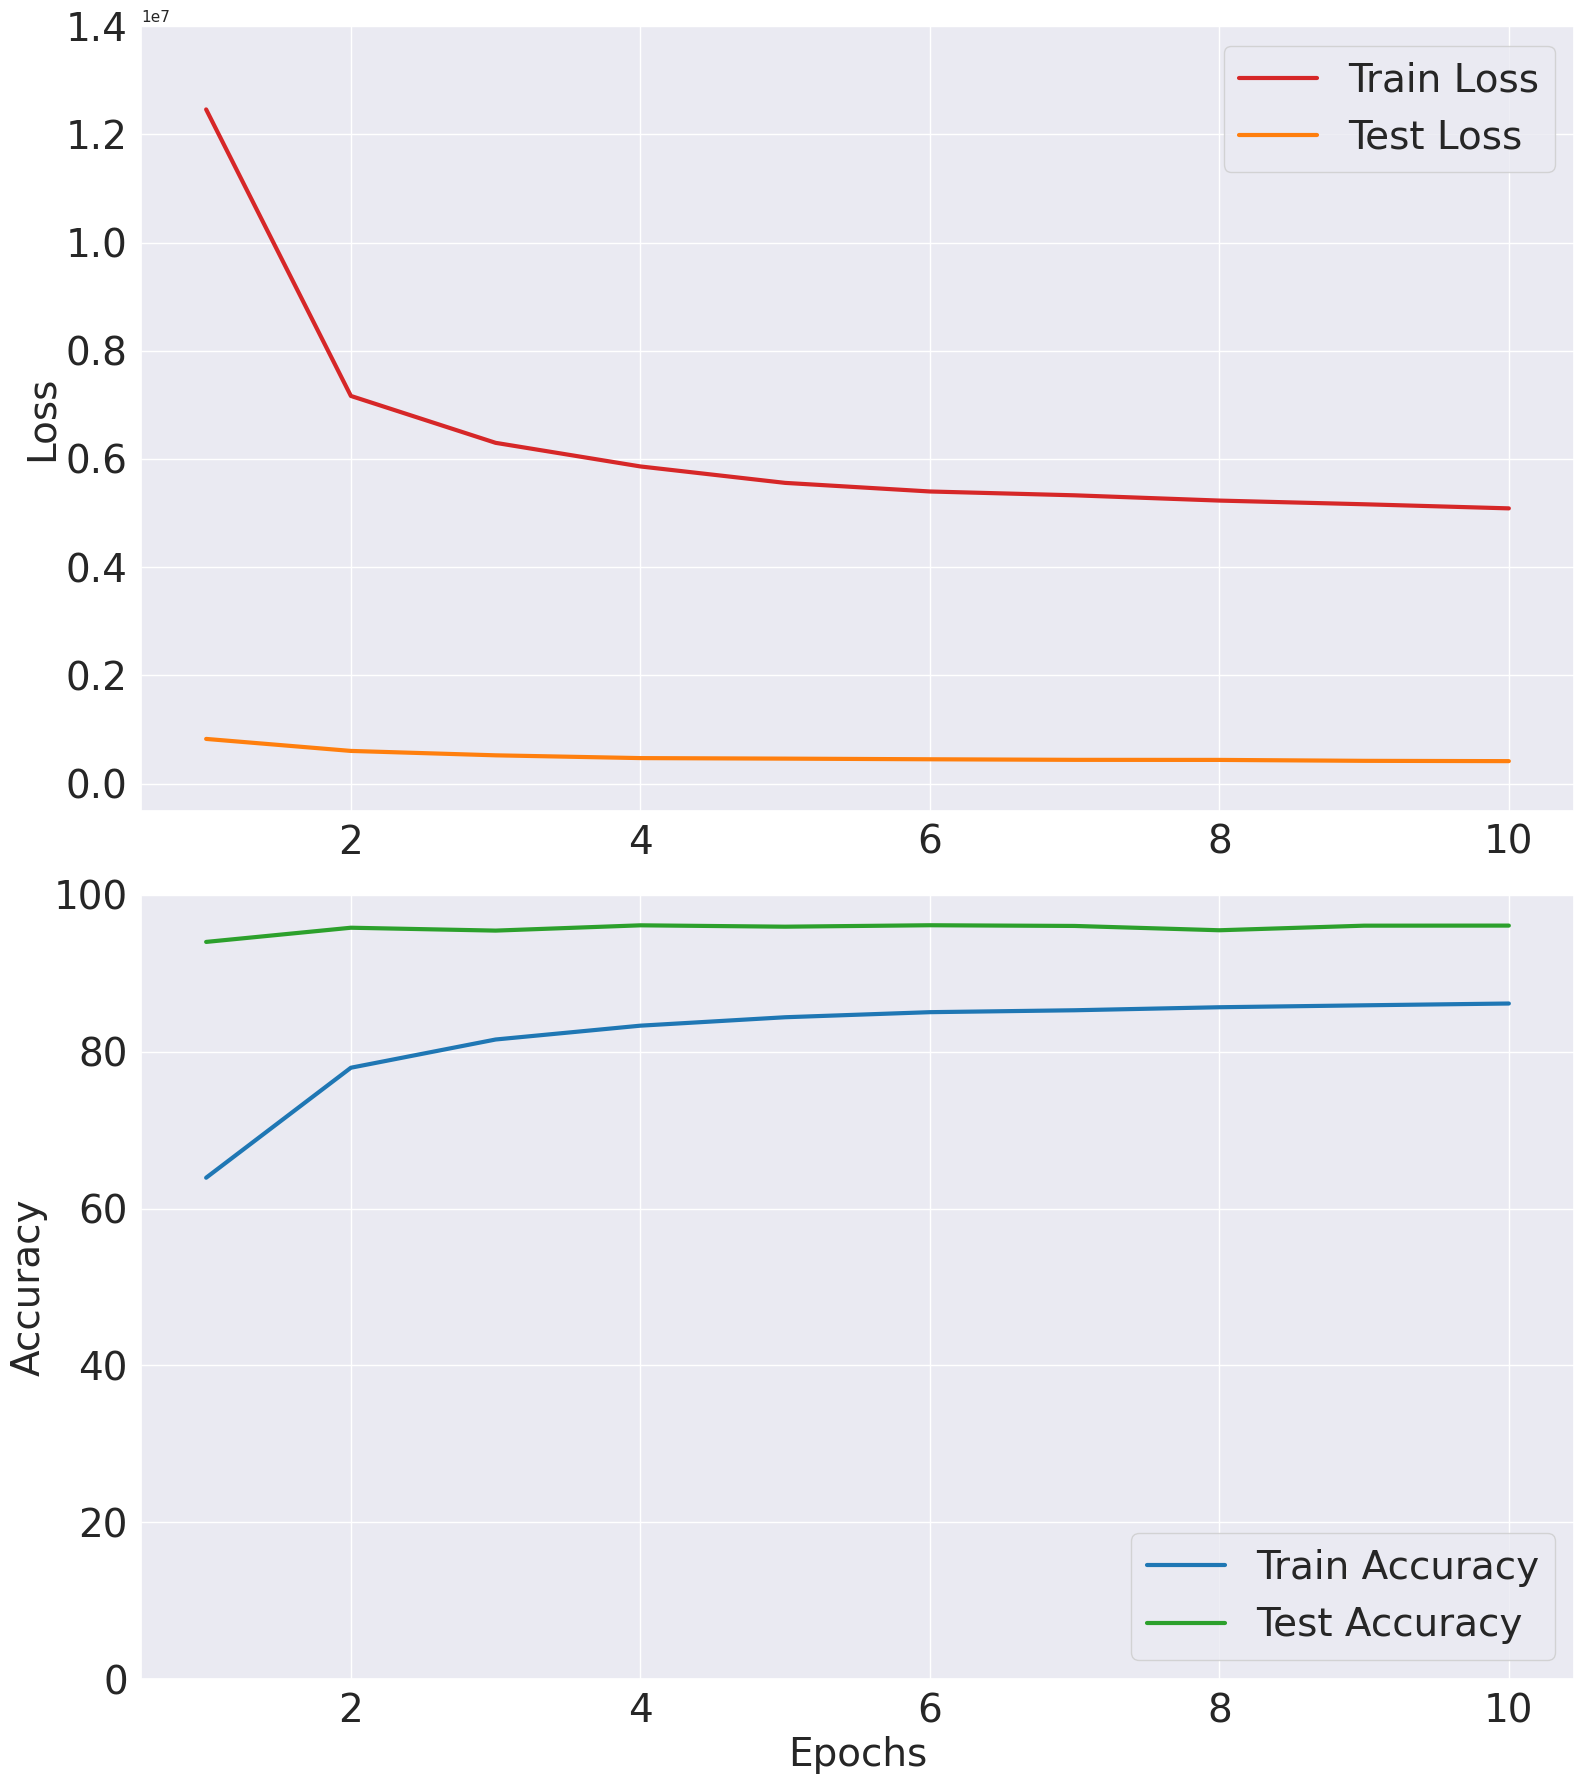

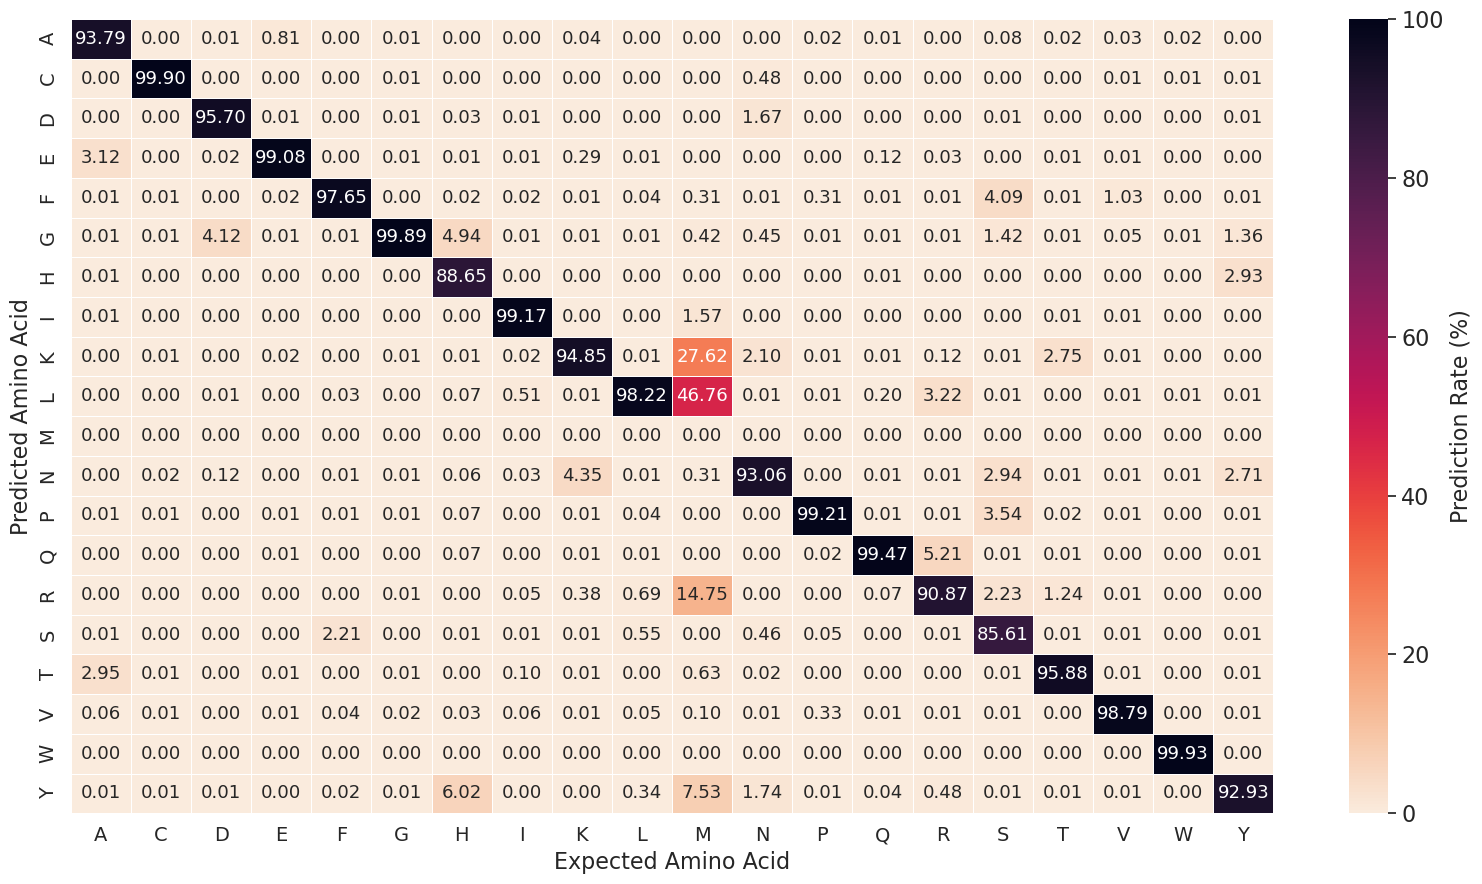

In [16]:
# Data/results directories
data_dir = f'.'
results_dir = f'./run_results/bert_mlm-esm_init'

# Create run directory for results
now = datetime.datetime.now()
date_hour_minute = now.strftime("%Y-%m-%d_%H-%M")
run_dir = os.path.join(results_dir, f"bert_mlm-esm_init-rbd-{date_hour_minute}")
os.makedirs(run_dir, exist_ok = True)

# Run setup
n_epochs = 10
batch_size = 64
max_batch = -1
num_workers = 64
lr = 1e-5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Create Dataset and DataLoader
torch.manual_seed(0)

train_dataset = RBDDataset(os.path.join(data_dir, "spikeprot0528.clean.uniq.noX.RBD.metadata.variants_train.csv"))
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=num_workers, pin_memory=True)

test_dataset = RBDDataset(os.path.join(data_dir, "spikeprot0528.clean.uniq.noX.RBD.metadata.variants_test.csv"))
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=num_workers, pin_memory=True)

# BERT input
max_len = 280
mask_prob = 0.15
embedding_dim = 320 
dropout = 0.1
n_transformer_layers = 12
n_attn_heads = 10

bert = BERT(embedding_dim, dropout, max_len, mask_prob, n_transformer_layers, n_attn_heads)
bert.embedding.load_pretrained_embeddings(os.path.join(data_dir, 'esm_weights-embedding_dim320.pth'), no_grad=False)
tokenizer = ProteinTokenizer(max_len, mask_prob)

model = ProteinLM(bert, vocab_size=27)

# Run
count_parameters(model)
saved_model_pth = None
from_checkpoint = False
save_as = f"bert_mlm-esm_init-rbd-train_{len(train_dataset)}_test_{len(test_dataset)}"
run_model(model, tokenizer, train_data_loader, test_data_loader, n_epochs, lr, max_batch, device, run_dir, save_as, saved_model_pth, from_checkpoint)

Let's try the checkpoint loading and stuffs.

+-----------------------------------------------------------+------------+
|                          Modules                          | Parameters |
+-----------------------------------------------------------+------------+
|           bert.embedding.token_embedding.weight           |    8640    |
|    bert.transformer_blocks.0.attention.linears.0.weight   |   102400   |
|     bert.transformer_blocks.0.attention.linears.0.bias    |    320     |
|    bert.transformer_blocks.0.attention.linears.1.weight   |   102400   |
|     bert.transformer_blocks.0.attention.linears.1.bias    |    320     |
|    bert.transformer_blocks.0.attention.linears.2.weight   |   102400   |
|     bert.transformer_blocks.0.attention.linears.2.bias    |    320     |
|    bert.transformer_blocks.0.attention.linears.3.weight   |   102400   |
|     bert.transformer_blocks.0.attention.linears.3.bias    |    320     |
|  bert.transformer_blocks.0.attention.output_linear.weight |   102400   |
|   bert.transformer_bloc

Epoch_test: 11: 100%|| 1086/1086 [02:00<00:00,  9.03it/s]

Epoch 11 | Train Accuracy: 83.6655, Train Loss: 5771295.3233
         | Test Accuracy: 95.9219, Test Loss: 457085.0261

Model and optimizer state saved to ./run_results/bert_mlm-esm_init/bert_mlm-esm_init-rbd-2024-09-24_20-18/checkpoint_saved_model.pth




Epoch_test: 12: 100%|| 1086/1086 [02:44<00:00,  6.60it/s]


Epoch 12 | Train Accuracy: 85.2678, Train Loss: 5333505.7357
         | Test Accuracy: 95.8372, Test Loss: 430923.0289

Model and optimizer state saved to ./run_results/bert_mlm-esm_init/bert_mlm-esm_init-rbd-2024-09-24_20-18/checkpoint_saved_model.pth

Training and testing complete in: 0 days, 16 hours, 42.548025 minutes.


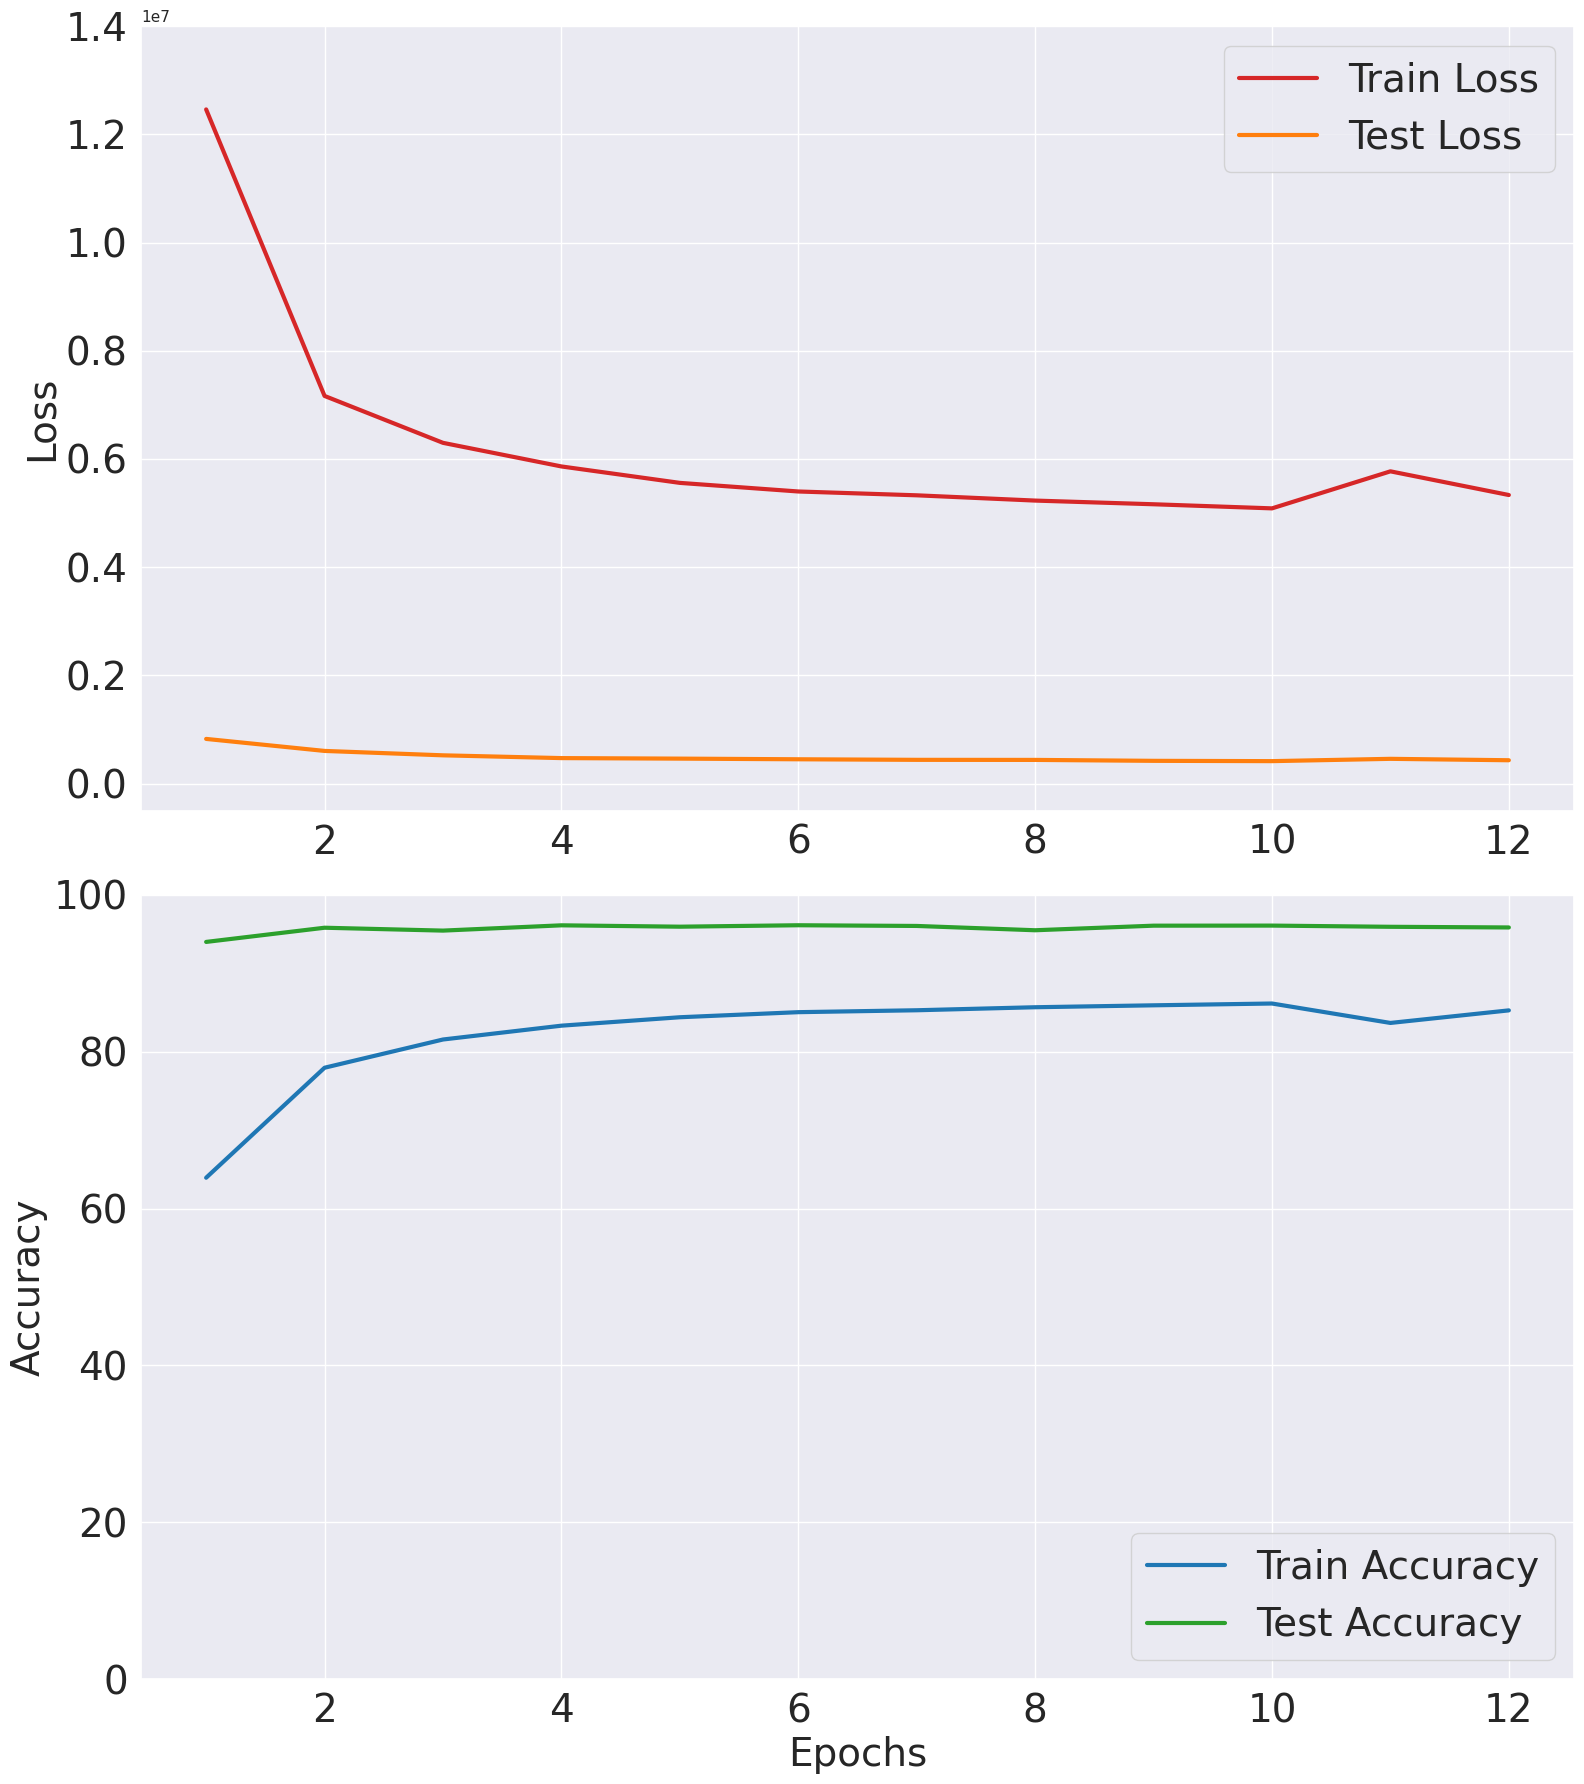

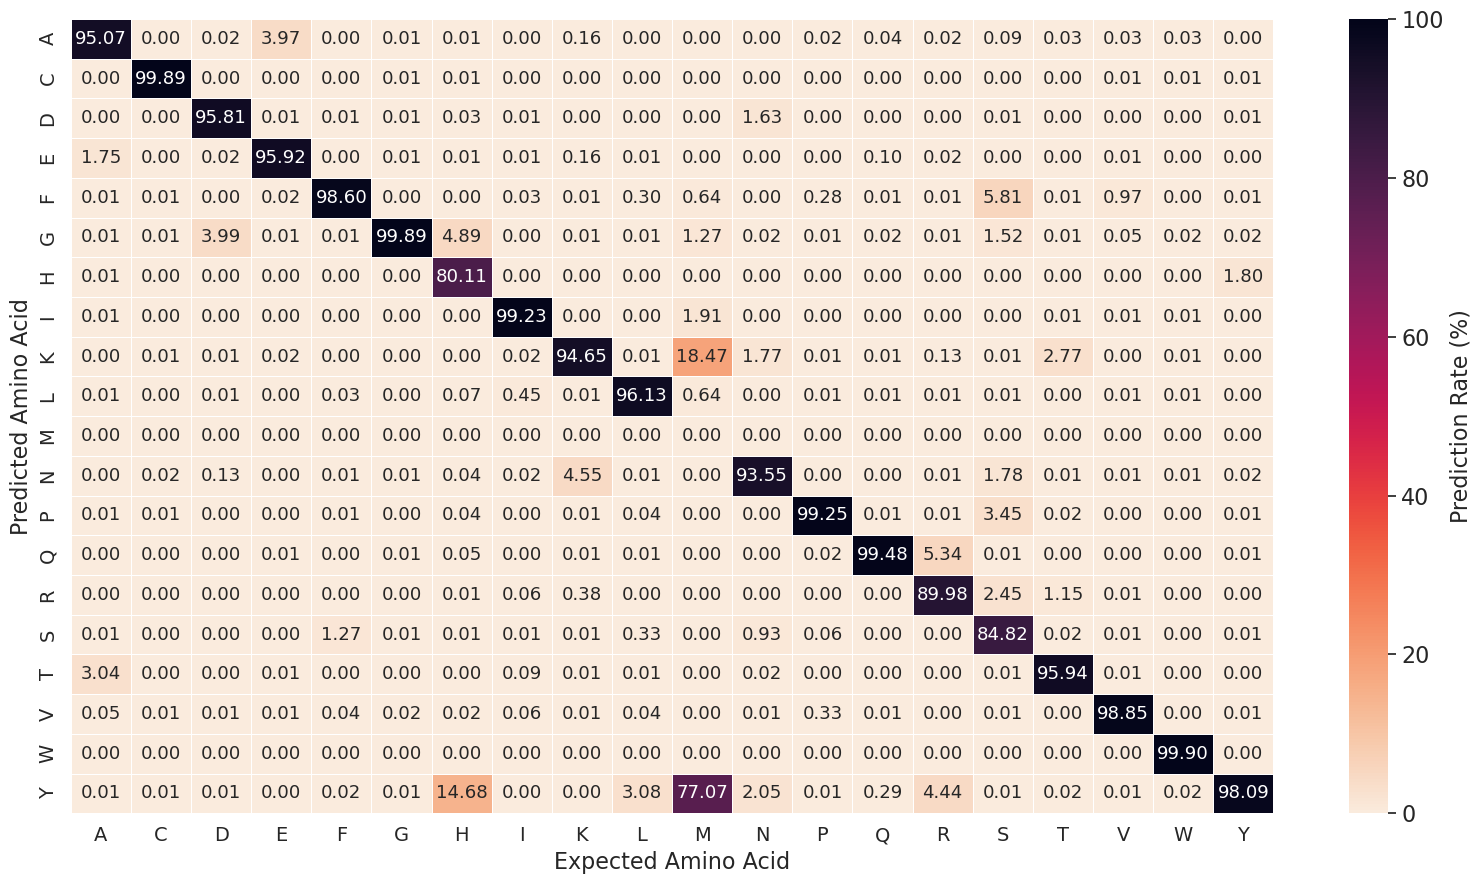

In [11]:
# Data/results directories
data_dir = f'.'
results_dir = f'./run_results/bert_mlm-esm_init'

# Create run directory for results
now = datetime.datetime.now()
date_hour_minute = now.strftime("%Y-%m-%d_%H-%M")
run_dir = os.path.join(results_dir, f"bert_mlm-esm_init-rbd-{date_hour_minute}")
os.makedirs(run_dir, exist_ok = True)

# Run setup
n_epochs = 12
batch_size = 64
max_batch = -1
num_workers = 64
lr = 1e-5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Create Dataset and DataLoader
torch.manual_seed(0)

train_dataset = RBDDataset(os.path.join(data_dir, "spikeprot0528.clean.uniq.noX.RBD.metadata.variants_train.csv"))
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=num_workers, pin_memory=True)

test_dataset = RBDDataset(os.path.join(data_dir, "spikeprot0528.clean.uniq.noX.RBD.metadata.variants_test.csv"))
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=num_workers, pin_memory=True)

# BERT input
max_len = 280
mask_prob = 0.15
embedding_dim = 320 
dropout = 0.1
n_transformer_layers = 12
n_attn_heads = 10

bert = BERT(embedding_dim, dropout, max_len, mask_prob, n_transformer_layers, n_attn_heads)
bert.embedding.load_pretrained_embeddings(os.path.join(data_dir, 'esm_weights-embedding_dim320.pth'), no_grad=False)
tokenizer = ProteinTokenizer(max_len, mask_prob)

model = ProteinLM(bert, vocab_size=27)

# Run
count_parameters(model)
saved_model_pth = "./run_results/bert_mlm-esm_init/mlm-esm_init-rbd-2024-09-24_18-26/checkpoint_saved_model.pth"
from_checkpoint = True
save_as = f"bert_mlm-esm_init-rbd-train_{len(train_dataset)}_test_{len(test_dataset)}"
run_model(model, tokenizer, train_data_loader, test_data_loader, n_epochs, lr, max_batch, device, run_dir, save_as, saved_model_pth, from_checkpoint)